In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from synth_ts.synth_timeserie_generator import *
import numpy as np

import changefinder
from scipy.signal import argrelextrema

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Benchmark dataset

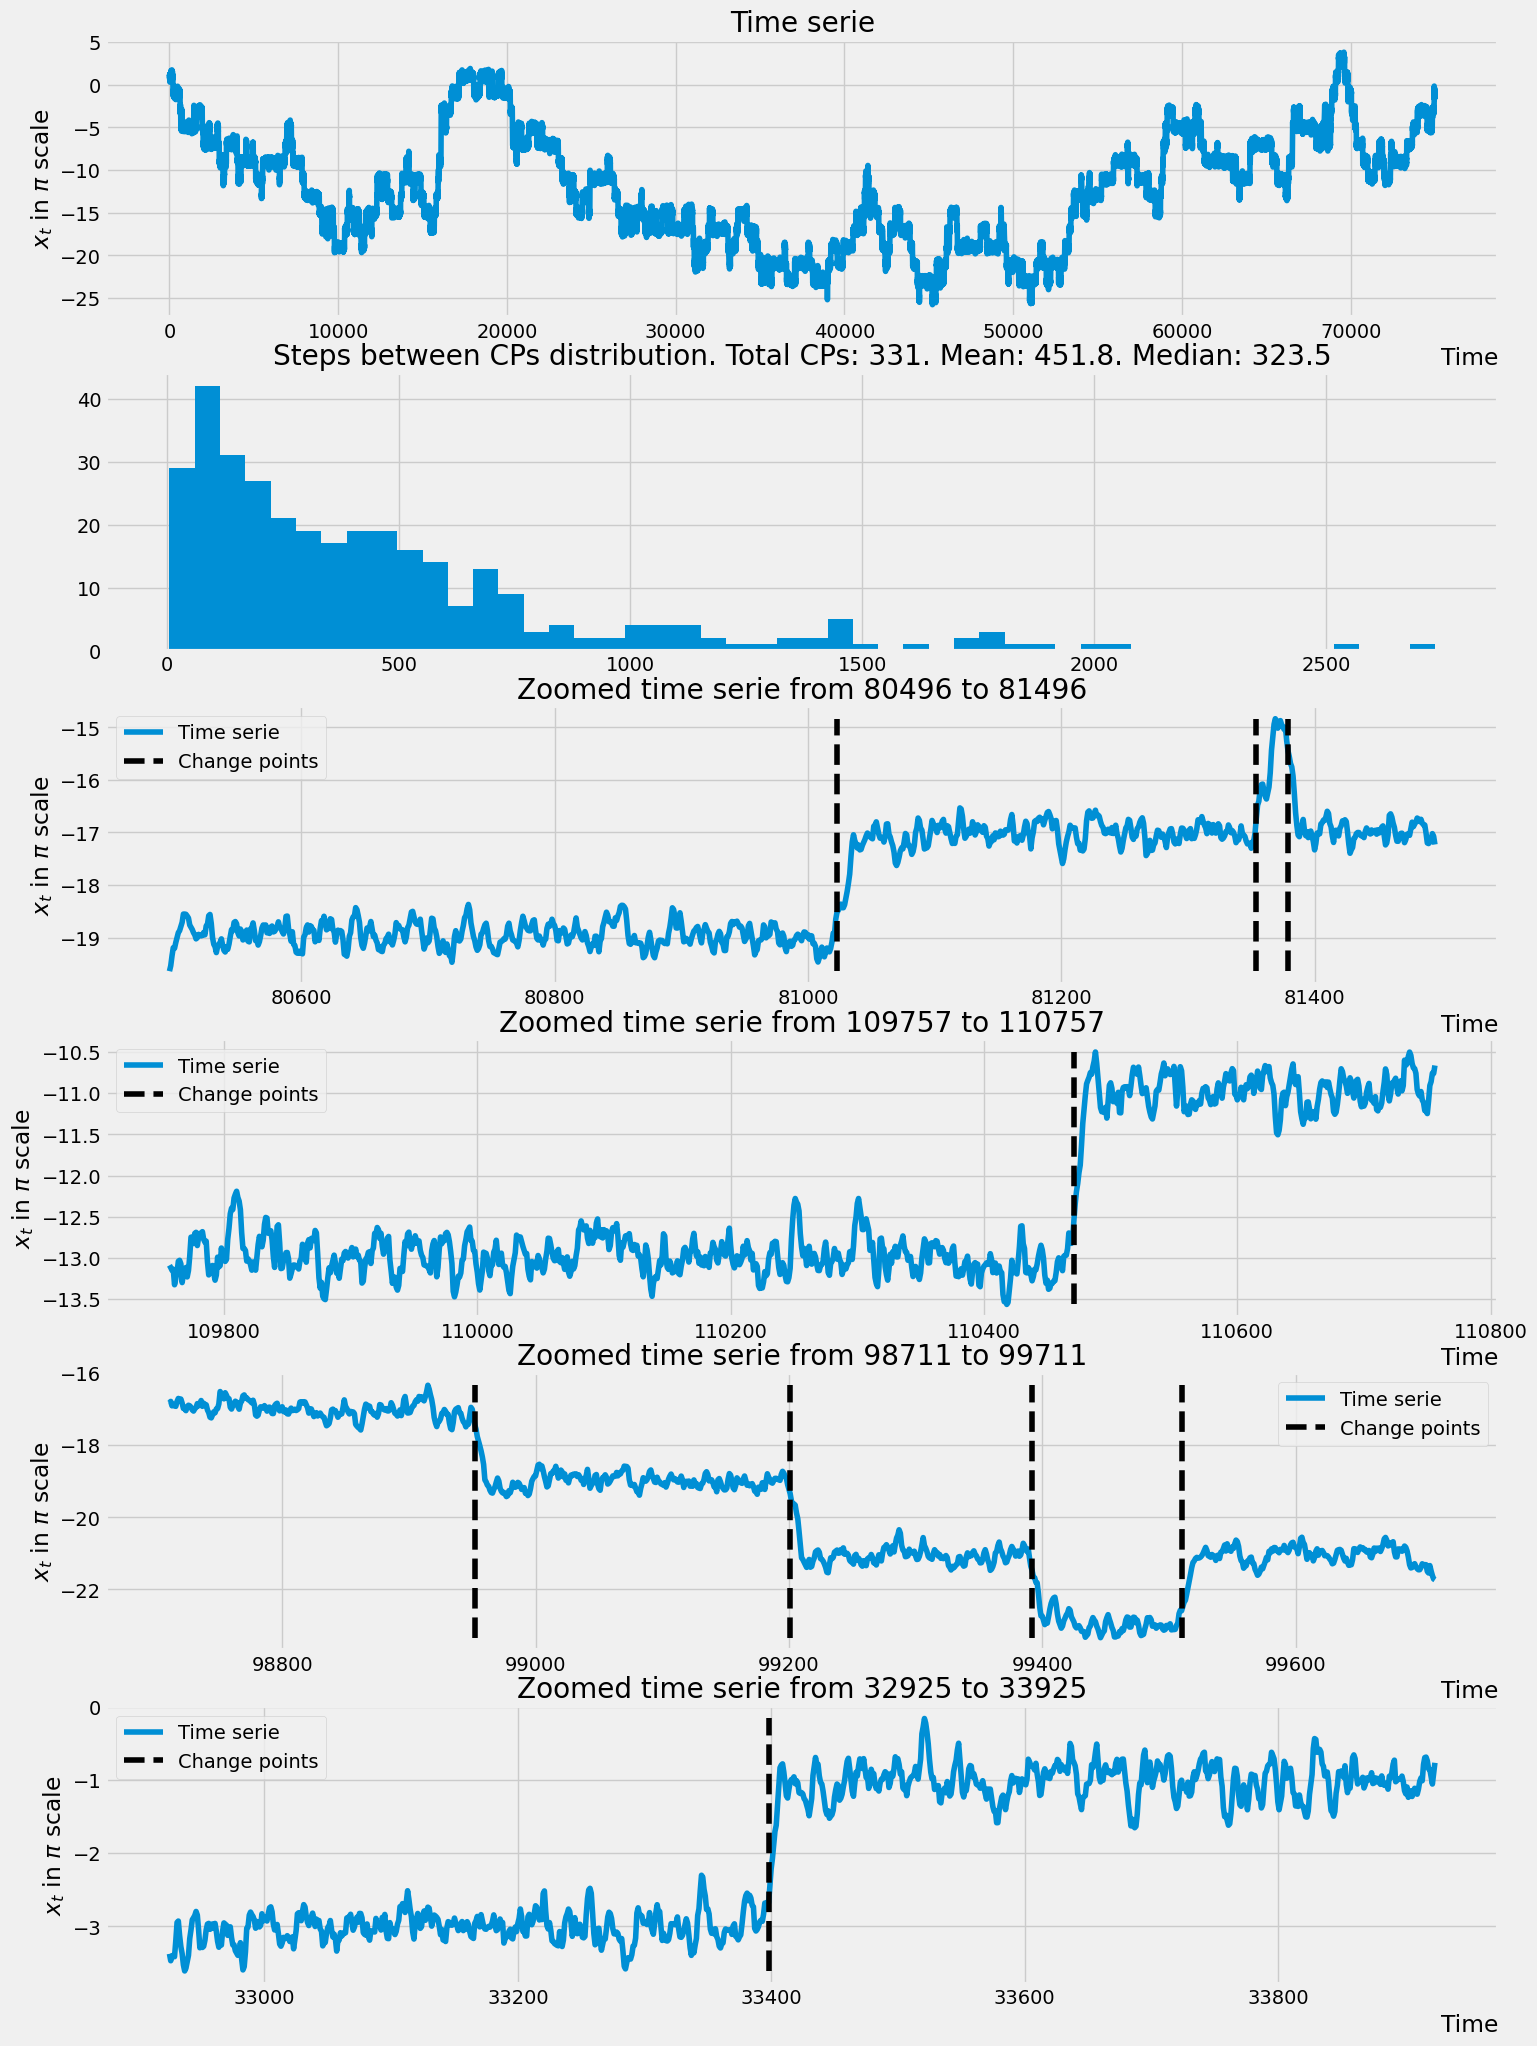

In [56]:
STEP_SIZE = 0.5
MIN_STABILITY_DURATION = 1
ID = '003'
TS_PARAMS = {
    'x0': np.pi,
    'lambd': 0.99,
    'n_steps': 150000,
    'alpha': 0.89,
}
integral_algo = IntegralAlgorithm(**TS_PARAMS)
ts, _ = integral_algo.generate(step_size=STEP_SIZE)
cp_ixs = find_change_points(ts, 1)
ts = demonstrate(TS_PARAMS, STEP_SIZE, ts, cp_ixs, bins=50, subseq_len=1000)

In [59]:
cp_ixs = np.array(cp_ixs)

Our `cp_ixs` show indexes before change so shift right:

In [60]:
cp_ixs += 1

In [87]:
a = np.array([0, 1, 1, 0])
len(np.where(a == 1)[0])

2

# Metric implementation

In [162]:
def ixs_to_label(size: int, ixs: np.array):
    labels = np.zeros(size)
    labels[ixs] = 1
    return labels

def lagged_tp(true_label, predict_label, lag):
    tp = 0
    for ix, label in enumerate(true_label):
        if label == 1:
            if len(np.where(predict_label[ix : ix + lag] == 1)[0]) > 0:
                tp += 1
    return tp
            
def lagged_recall(tp, predict_label):
    if len(np.where(predict_label == 1)[0]) == 0:
        return 0
    return tp / len(np.where(predict_label == 1)[0])

def lagged_precision(tp, true_label):
    if len(np.where(true_label == 1)[0]) == 0:
        return 0
    return tp / len(np.where(true_label == 1)[0])

def annotation_error(true_cps, predict_cps, is_train, T, ts_size):
    true_label = ixs_to_label(ts_size, true_cps)
    predict_label = ixs_to_label(ts_size, predict_cps)
    if is_train:
        true_label = true_label[:T]
        predict_label = predict_label[:T]
    else:
        true_label = true_label[T:]
        predict_label = predict_label[T:]

    return np.abs(len(np.where(true_label == 1)[0]) - len(np.where(predict_label == 1)[0]))

def lagged_classification_metric(true_cps, predict_cps, lag, ts_size, is_train, T):
    # Return precision, recall, F1
    true_label = ixs_to_label(ts_size, true_cps)
    predict_label = ixs_to_label(ts_size, predict_cps)
    if is_train:
        true_label = true_label[:T]
        predict_label = predict_label[:T]
    else:
        true_label = true_label[T:]
        predict_label = predict_label[T:]

    tp = lagged_tp(true_label, predict_label, lag)
    recall = lagged_recall(tp, predict_label)
    precision = lagged_precision(tp, true_label)

    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    return precision, recall, f1

In [76]:
def visualize(data, cp_true, cp_predict, LB=None, RB=None, true_lag=0):
    data = data / np.pi

    if LB is None:
        LB = 0
        RB = len(data)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))
    ax1.plot(np.arange(LB, RB), data[LB:RB], alpha=0.5, label='timeserie')
    
    true_use_ixs = cp_true[np.where(LB <= cp_true)]
    true_use_ixs = true_use_ixs[np.where(true_use_ixs < RB)]
    true_use_ixs += true_lag
    ax1.scatter(x=true_use_ixs, y=data[true_use_ixs], color='green', label='true cps')

    predict_use_ixs = cp_predict[np.where(LB <= cp_predict)]
    predict_use_ixs = predict_use_ixs[np.where(predict_use_ixs < RB)]
    ax1.scatter(predict_use_ixs, y=data[predict_use_ixs], color='red', label='predict cps')
    ax1.legend()
    data = data * np.pi

# Bayessian CPD:

In [63]:
import bocd

det = bocd.BayesianOnlineChangePointDetection(bocd.ConstantHazard(300), bocd.StudentT(mu=0, kappa=1, alpha=1, beta=1))
rt_mle = np.empty(ts.shape)
iterator = list(enumerate(ts))
for i, d in tqdm(iterator):
    det.update(d)
    rt_mle[i] = det.rt 

  0%|          | 0/150000 [00:00<?, ?it/s]

/home/dzhunki/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6408: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))
/home/dzhunki/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6408: RuntimeWarning: overflow encountered in multiply
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))


In [64]:
with open('cp_compare/bayessian_000.npy', 'wb') as f:
    np.save(f, rt_mle)

In [70]:
cp_predict = np.where(np.diff(rt_mle) < 0)[0]

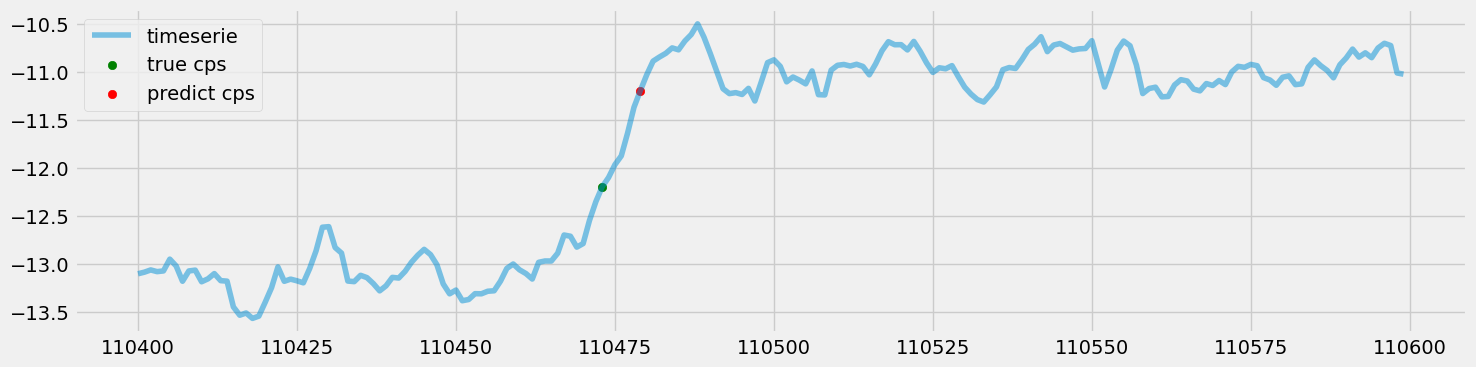

In [82]:
visualize(ts, cp_ixs, cp_predict, LB=110400, RB=110600)

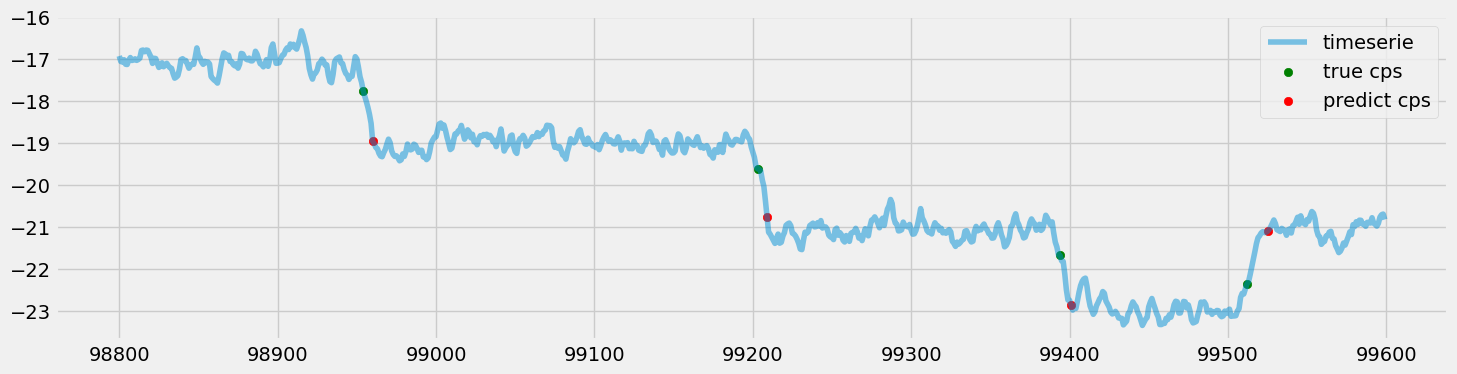

In [83]:
visualize(ts, cp_ixs, cp_predict, LB=98800, RB=99600)

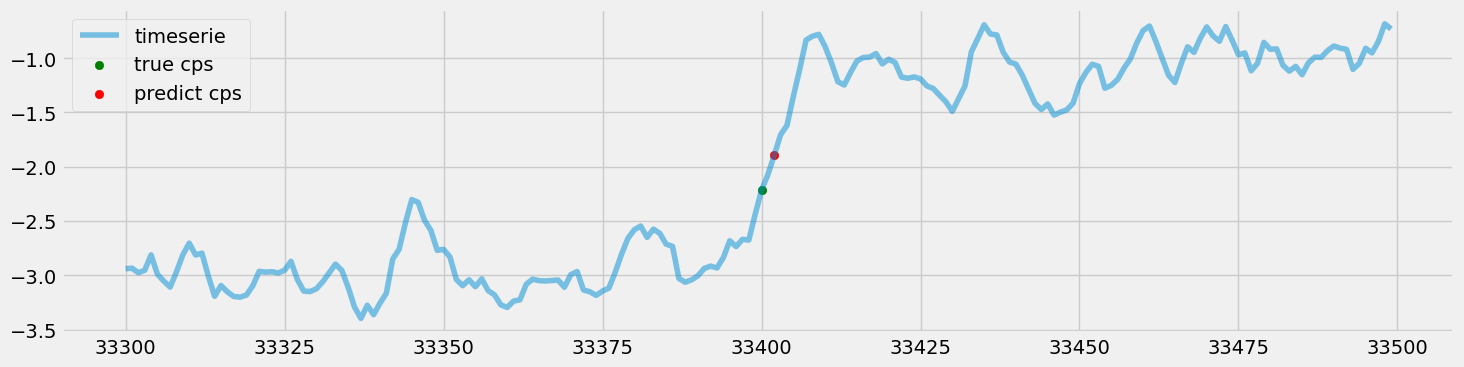

In [73]:
visualize(ts, cp_ixs, cp_predict, LB=33300, RB=33500)

In [164]:
with open('cp_compare/bayessian_000.npy', 'rb') as f:
    rt_mle = np.load(f)

cp_predict = np.where(np.diff(rt_mle) < 0)[0]
p, r, f = lagged_classification_metric(cp_ixs, cp_predict, lag=10, ts_size=len(ts), is_train=False, T=100000)
ae = annotation_error(cp_ixs, cp_predict, is_train=False, T=100000, ts_size=len(ts))
print(f'Precision: {p}. Recall: {r}. F1: {f}. AnnotationError: {ae}')

Precision: 0.9150943396226415. Recall: 0.7132352941176471. F1: 0.8016528925619835. AnnotationError: 30


# PELT

In [94]:
T = 100000

ts_train = ts[:T]
ts_test = ts[T:]

In [99]:
true_cps_train = find_change_points(ts_train, 1)
true_cps_train = np.array(true_cps_train)

In [100]:
true_cps_test = find_change_points(ts_test, 1)
true_cps_test = np.array(true_cps_test)

In [116]:
import optuna
import ruptures as rpt

def pelt_objective(trial):
    kernel = trial.suggest_categorical('model', ['l1', 'l2'])
    min_size = trial.suggest_int('min_size', 10, 20)
    jump = trial.suggest_int('jump', 3, 20)
    pen = trial.suggest_int('pen', 2, 25)

    algo = rpt.Pelt(model=kernel, min_size=min_size, jump=jump)
    algo.fit(ts_train)
    cps = algo.predict(pen=pen)
    cps = np.array(cps)

    _, _, f = lagged_classification_metric(true_cps_train, cps, lag=10, ts_size=len(ts))
    return f

In [106]:
import ruptures as rpt

model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=10, jump=5).fit(ts_train)
my_bkps = algo.predict(pen=10)
my_bkps = np.array(my_bkps)

In [107]:
p, r, f = lagged_classification_metric(true_cps_train, my_bkps, lag=10, ts_size=len(ts))
print(f'Precision: {p}. Recall: {r}. F1: {f}')

Precision: 0.96. Recall: 0.37828371278458844. F1: 0.542713567839196


In [118]:
opt = optuna.create_study(direction='maximize')
opt.optimize(pelt_objective, n_trials=60)

[I 2023-05-18 01:44:52,578] A new study created in memory with name: no-name-593dff68-9c58-468f-aaed-cc1ca036a706
[I 2023-05-18 01:45:27,461] Trial 0 finished with value: 0.42397336293007776 and parameters: {'model': 'l1', 'min_size': 19, 'jump': 8, 'pen': 7}. Best is trial 0 with value: 0.42397336293007776.
[I 2023-05-18 01:45:34,013] Trial 1 finished with value: 0.27488151658767773 and parameters: {'model': 'l2', 'min_size': 18, 'jump': 19, 'pen': 14}. Best is trial 0 with value: 0.42397336293007776.
[I 2023-05-18 01:48:26,576] Trial 2 finished with value: 0.53315649867374 and parameters: {'model': 'l2', 'min_size': 20, 'jump': 3, 'pen': 18}. Best is trial 2 with value: 0.53315649867374.
[I 2023-05-18 01:49:04,110] Trial 3 finished with value: 0.1681184668989547 and parameters: {'model': 'l2', 'min_size': 16, 'jump': 5, 'pen': 4}. Best is trial 2 with value: 0.53315649867374.
[I 2023-05-18 01:50:48,846] Trial 4 finished with value: 0.46658851113716293 and parameters: {'model': 'l1', 

In [158]:
import ruptures as rpt

model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model='l2', min_size=20, jump=3).fit(ts)
my_bkps = algo.predict(pen=18)
my_bkps = np.array(my_bkps)

In [166]:
my_bkps -= 1

In [167]:
p, r, f = lagged_classification_metric(cp_ixs, my_bkps, lag=10, ts_size=len(ts), is_train=False, T=100000)
ae = annotation_error(cp_ixs, my_bkps, is_train=False, T=100000, ts_size=len(ts))

print(f'Precision: {p}. Recall: {r}. F1: {f}. AnnotationError: {ae}')

Precision: 0.8301886792452831. Recall: 0.3492063492063492. F1: 0.4916201117318436. AnnotationError: 146


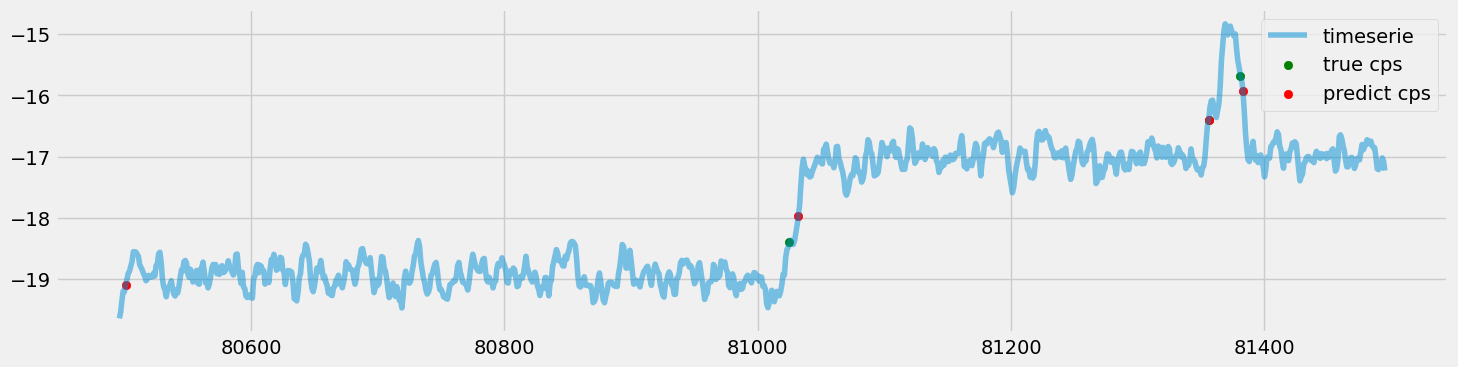

In [178]:
visualize(ts, cp_ixs, my_bkps, LB=80496, RB=81496)

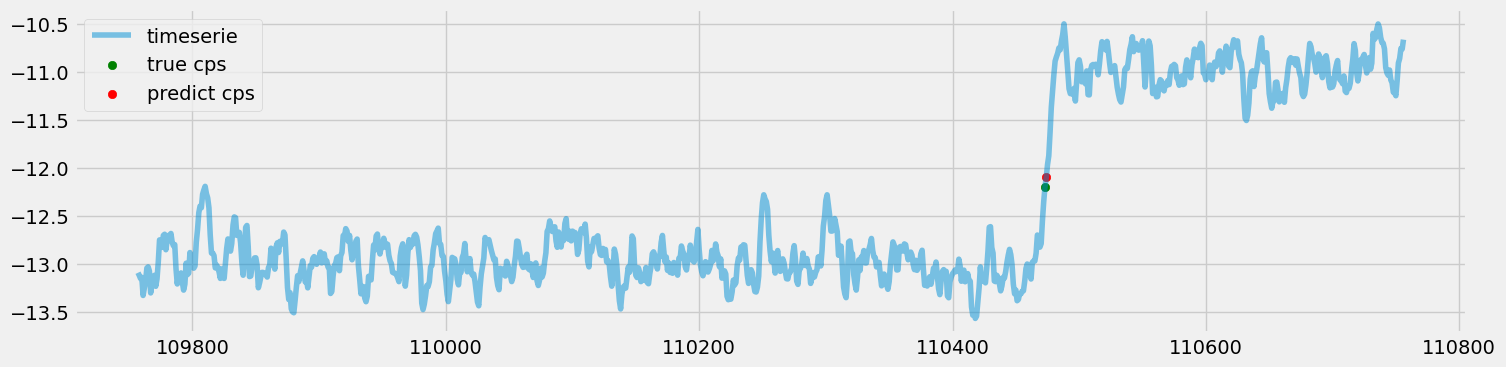

In [179]:
visualize(ts, cp_ixs, my_bkps, LB=109757, RB=110757)

# ChangeFinder

In [128]:
def changeFinderTS(data, r, order, smooth):
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    scores = [cf.update(i) for i in data]
    return np.array(scores)

def visualize_cf(data, scores, cp_true, LB = None, RB = None):
    data = data / np.pi
    if LB is None:
        LB = 0
        RB = len(data)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))
    ax2 = ax1.twinx()
    ax1.plot(np.arange(LB, RB), data[LB:RB], label='timeserie', alpha=0.5)
    ax2.plot(np.arange(LB, RB), scores[LB:RB], label='CF CP score', color='red', alpha=0.5)

    ax1.set_ylabel(r'$x_t$')
    ax1.grid(axis='x', alpha=0.7)
    ax1.set_xlabel(r'$t$')
    use_ixs = cp_true[np.where(LB <= cp_true)]
    use_ixs = use_ixs[np.where(use_ixs < RB)]
    ax1.scatter(use_ixs, data[use_ixs], color='green')

    ax2.set_ylabel('CP score')
    plt.show()

    data = data * np.pi

In [134]:
scores = changeFinderTS(ts_train, r=0.03, order=1, smooth=5)

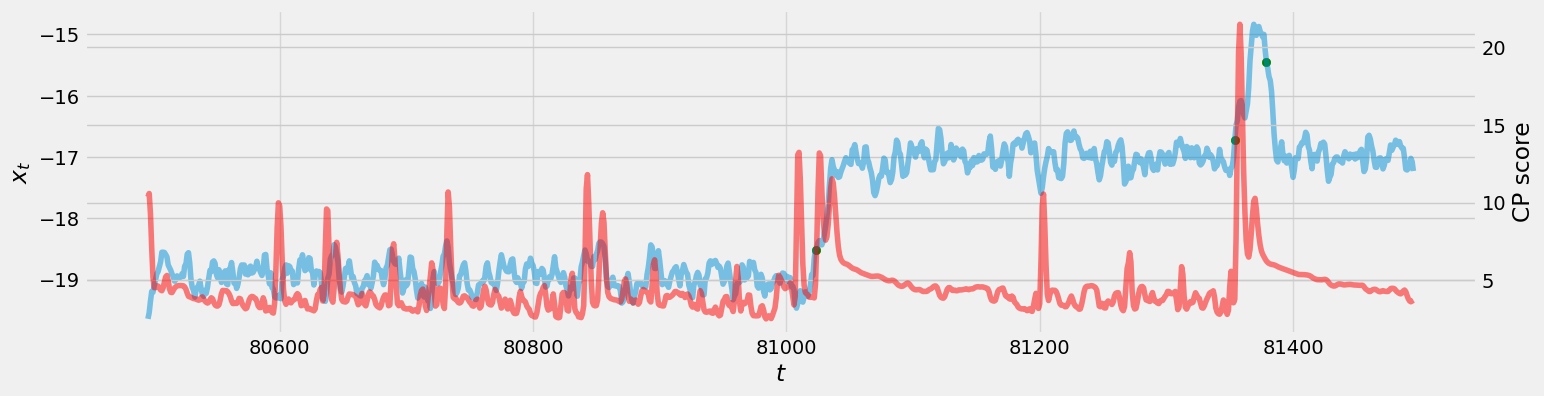

In [135]:
visualize_cf(ts_train, scores, true_cps_train, LB=80496, RB=81496)

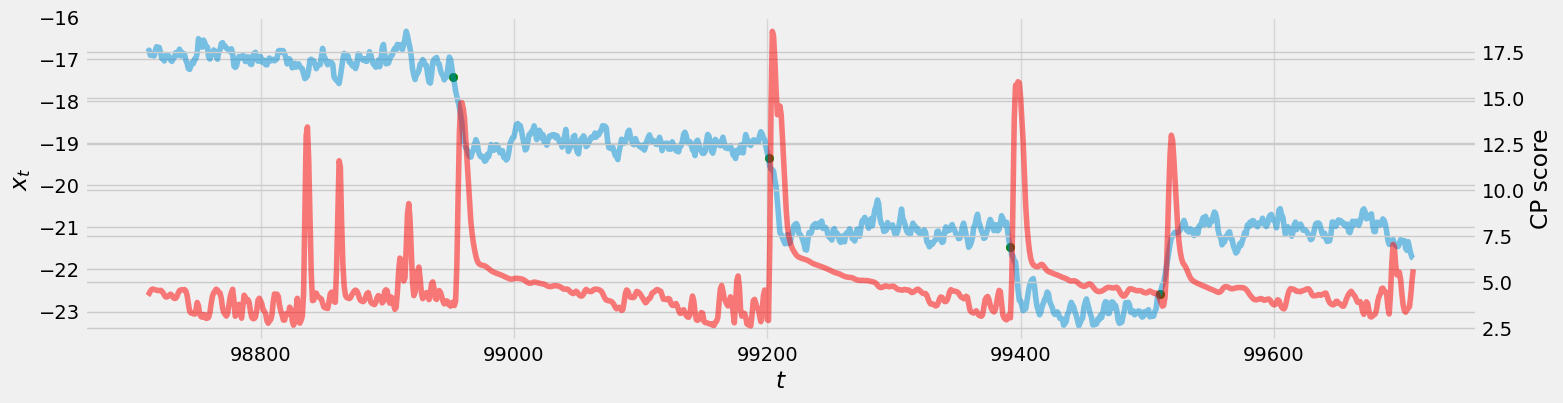

In [136]:
visualize_cf(ts_train, scores, true_cps_train, LB=98711, RB=99711)

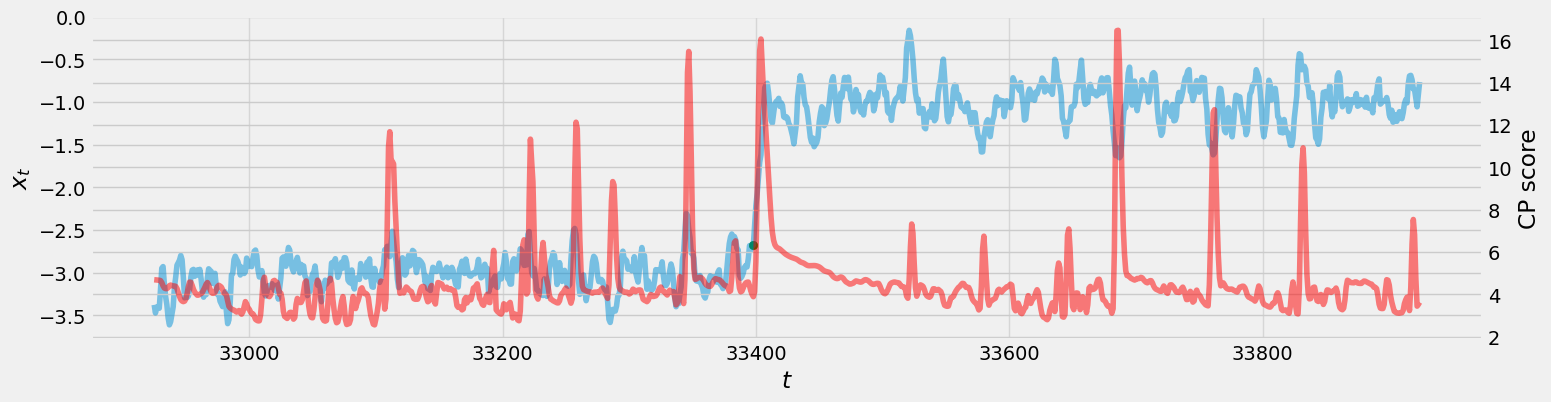

In [137]:
visualize_cf(ts_train, scores, true_cps_train, LB=32925, RB=33925)

In [153]:
def cf_objective(trial):
    r = trial.suggest_float('r', 0.01, 0.1)
    order = trial.suggest_categorical('order', [1, 2, 3])
    smooth = trial.suggest_int('smooth', 3, 7)
    
    threshold = trial.suggest_int('t', 6, 20)
    scores = changeFinderTS(ts_train, r, order, smooth)
    extrems = argrelextrema(scores, np.greater)[0]
    cps = extrems[np.where(scores[extrems] > threshold)]
    _, _, f = lagged_classification_metric(true_cps_train, cps, lag=10, ts_size=len(ts_train)+1)
    return f

In [156]:
opt = optuna.create_study(direction='maximize')
opt.optimize(cf_objective, n_trials=60)

[I 2023-05-18 11:18:26,861] A new study created in memory with name: no-name-ca3b1785-afa2-43e1-8c59-20198812b9ed
[I 2023-05-18 11:18:37,009] Trial 0 finished with value: 0.0 and parameters: {'r': 0.07698349538308114, 'order': 3, 'smooth': 4, 't': 18}. Best is trial 0 with value: 0.0.
[I 2023-05-18 11:18:44,253] Trial 1 finished with value: 0.006451612903225806 and parameters: {'r': 0.05105979595498036, 'order': 2, 'smooth': 6, 't': 18}. Best is trial 1 with value: 0.006451612903225806.
[I 2023-05-18 11:18:51,364] Trial 2 finished with value: 0.037627067212866024 and parameters: {'r': 0.05274582884211971, 'order': 2, 'smooth': 7, 't': 11}. Best is trial 2 with value: 0.037627067212866024.
[I 2023-05-18 11:18:57,131] Trial 3 finished with value: 0.33639143730886845 and parameters: {'r': 0.022388687405351344, 'order': 1, 'smooth': 4, 't': 10}. Best is trial 3 with value: 0.33639143730886845.
[I 2023-05-18 11:19:06,966] Trial 4 finished with value: 0.11354046797084771 and parameters: {'r'

In [168]:
r = 0.028
order = 1
smooth = 5
threshold = 15

scores = changeFinderTS(ts, r, order, smooth)
extrems = argrelextrema(scores, np.greater)[0]
cps = extrems[np.where(scores[extrems] > threshold)]

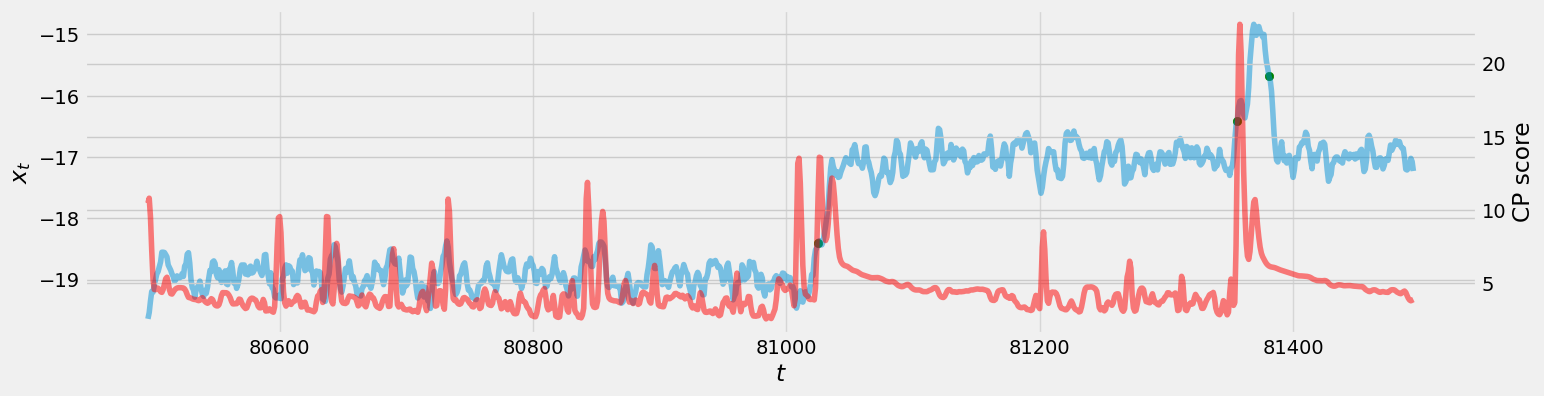

In [169]:
visualize_cf(ts, scores, cp_ixs, LB=80496, RB=81496)

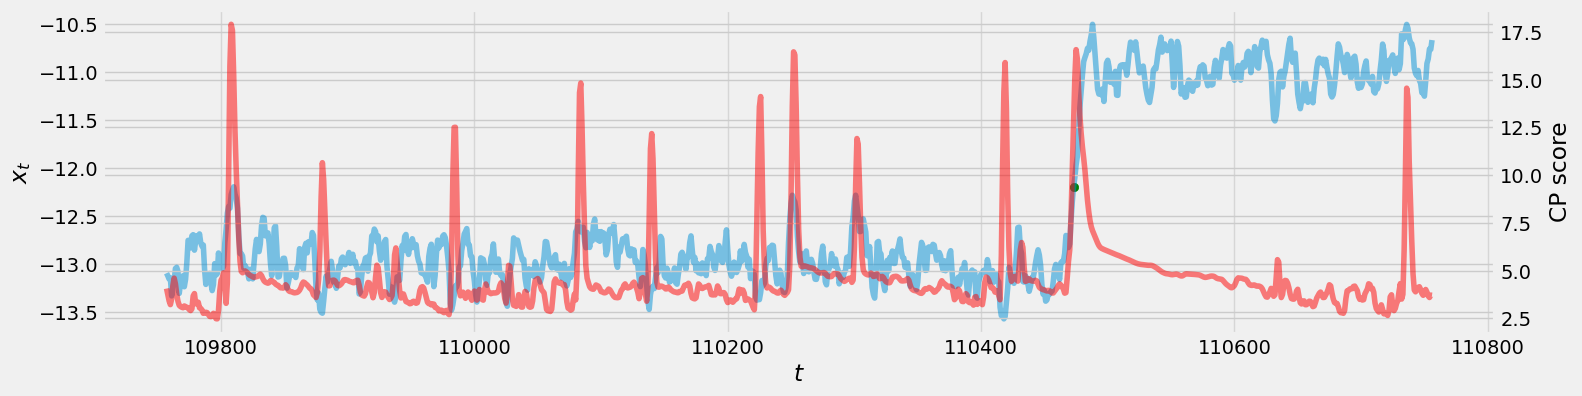

In [170]:
visualize_cf(ts, scores, cp_ixs, LB=109757, RB=110757)

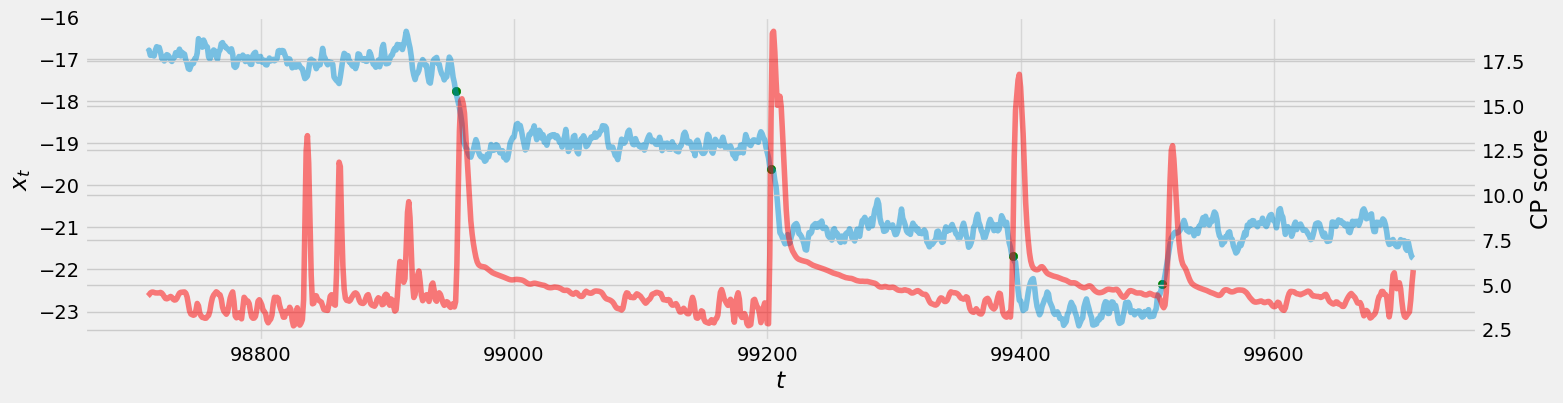

In [171]:
visualize_cf(ts, scores, cp_ixs, LB=98711, RB=99711)

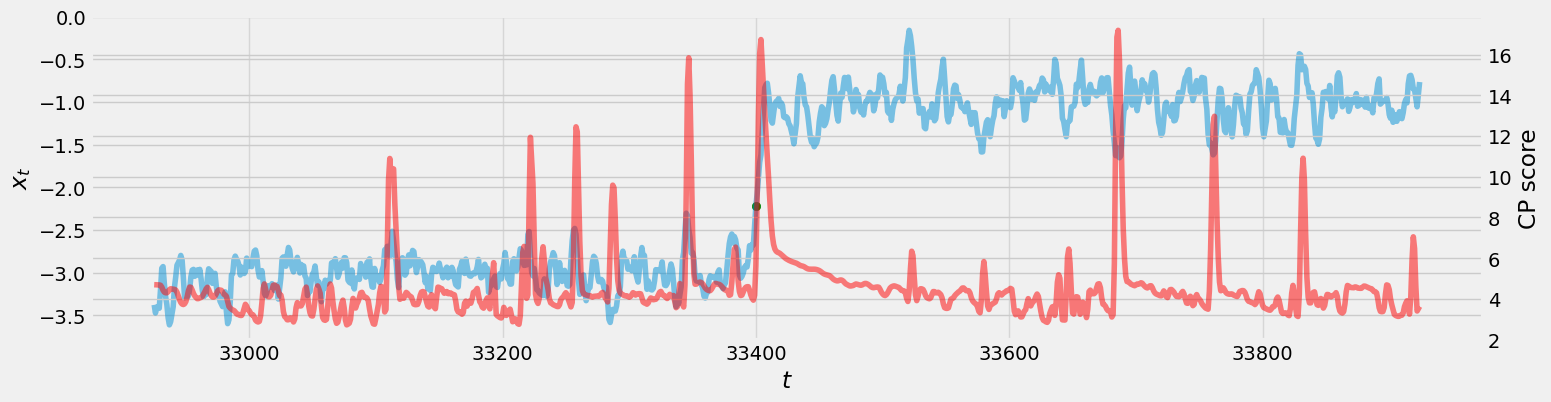

In [172]:
visualize_cf(ts, scores, cp_ixs, LB=32925, RB=33925)

In [173]:
p, r, f = lagged_classification_metric(cp_ixs, cps, lag=10, ts_size=len(ts), is_train=False, T=100000)
ae = annotation_error(cp_ixs, cps, is_train=False, T=100000, ts_size=len(ts))

print(f'Precision: {p}. Recall: {r}. F1: {f}. AnnotationError: {ae}')

Precision: 0.5377358490566038. Recall: 0.41911764705882354. F1: 0.47107438016528924. AnnotationError: 30


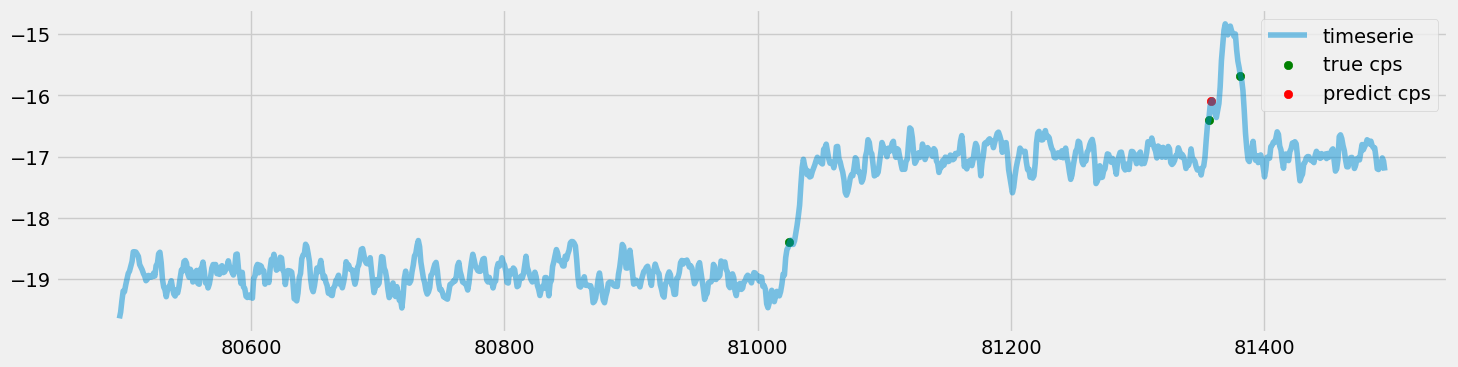

In [174]:
visualize(ts, cp_ixs, cps, LB=80496, RB=81496)

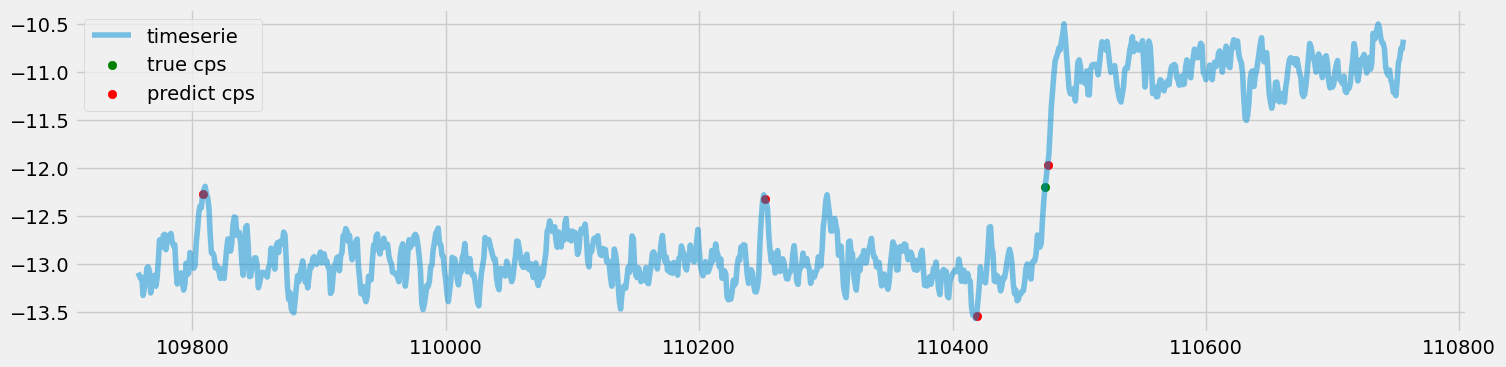

In [175]:
visualize(ts, cp_ixs, cps, LB=109757, RB=110757)

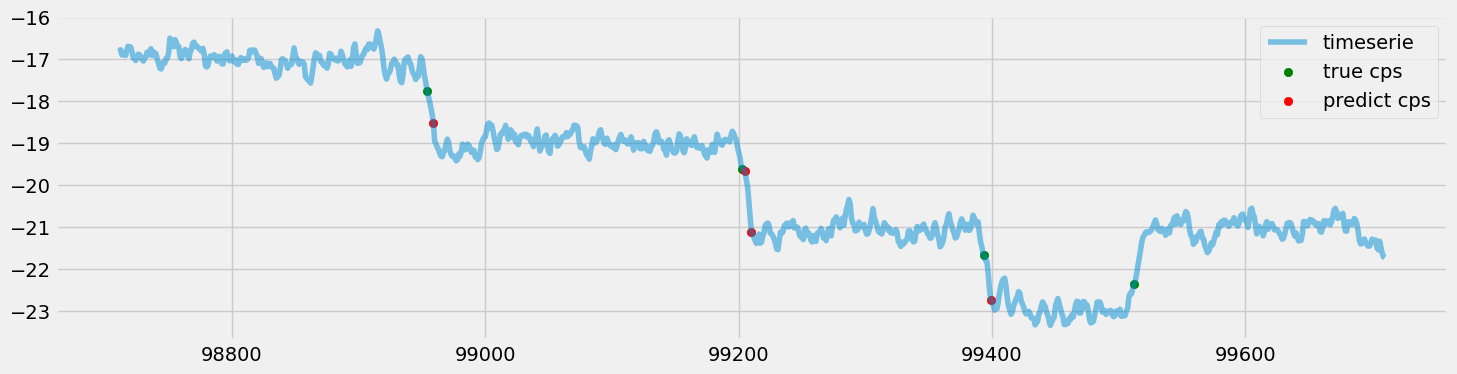

In [176]:
visualize(ts, cp_ixs, cps, LB=98711, RB=99711)

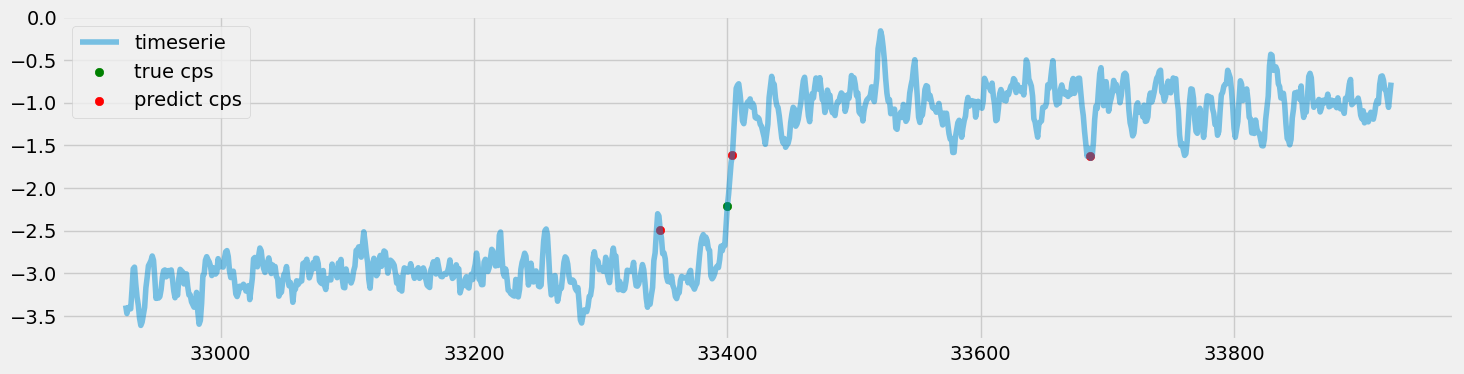

In [177]:
visualize(ts, cp_ixs, cps, LB=32925, RB=33925)

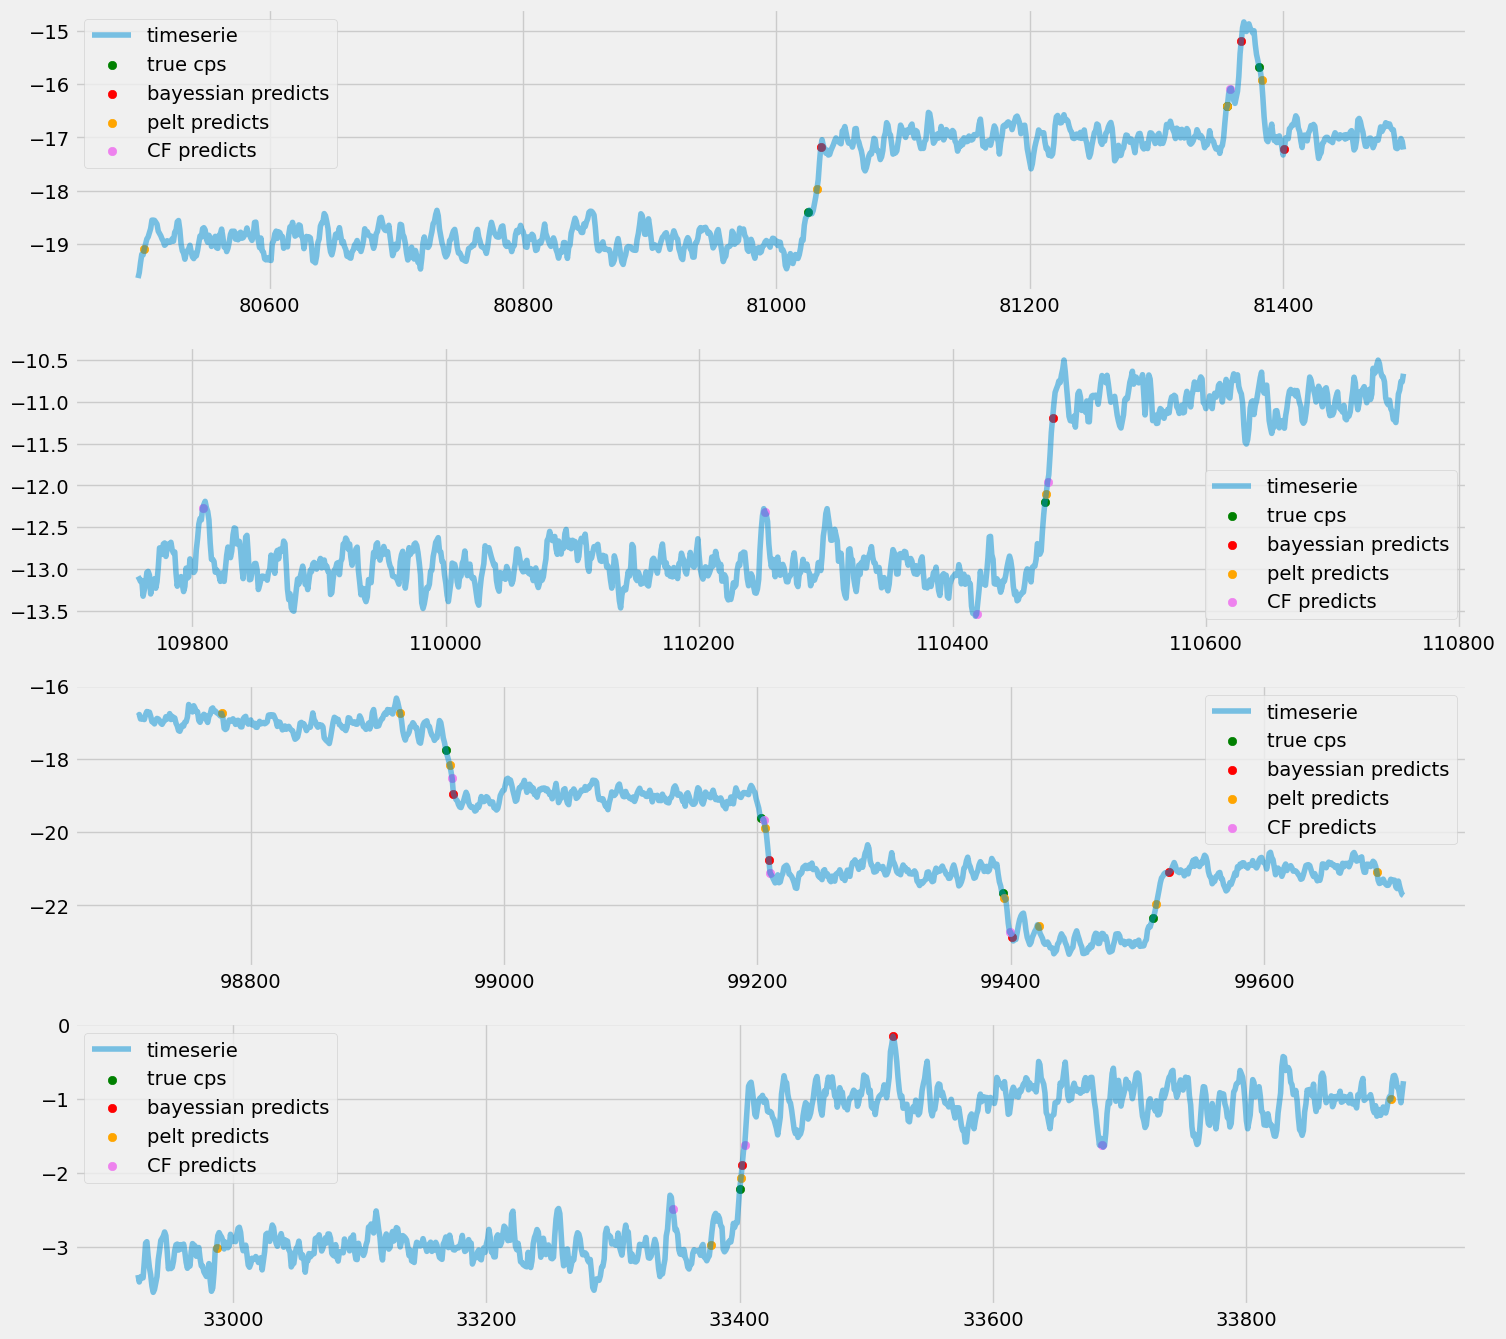

In [181]:
fig, axs = plt.subplots(4, 1, figsize=(16,16))

# ax1.plot(np.arange(LB, RB), data[LB:RB], alpha=0.5, label='timeserie')

# true_use_ixs = cp_true[np.where(LB <= cp_true)]
# true_use_ixs = true_use_ixs[np.where(true_use_ixs < RB)]
# true_use_ixs += true_lag
# ax1.scatter(x=true_use_ixs, y=data[true_use_ixs], color='green', label='true cps')

# predict_use_ixs = cp_predict[np.where(LB <= cp_predict)]
# predict_use_ixs = predict_use_ixs[np.where(predict_use_ixs < RB)]
# ax1.scatter(predict_use_ixs, y=data[predict_use_ixs], color='red', label='predict cps')
# ax1.legend()
# data = data * np.pi

ts = ts / np.pi
LBS = [80496, 109757, 98711, 32925]
RBS = [81496, 110757, 99711, 33925]
for i in range(4):
    LB = LBS[i]
    RB = RBS[i]
    axs[i].plot(np.arange(LB, RB), ts[LB:RB], alpha=0.5, label='timeserie')
    true_use_ixs = cp_ixs[np.where(LB <= cp_ixs)]
    true_use_ixs = true_use_ixs[np.where(true_use_ixs < RB)]
    axs[i].scatter(x=true_use_ixs, y=ts[true_use_ixs], color='green', label='true cps')

    bayessian_predict = cp_predict[np.where(LB <= cp_predict)]
    bayessian_predict = bayessian_predict[np.where(bayessian_predict < RB)]
    axs[i].scatter(bayessian_predict, y=ts[bayessian_predict], color='red', label='bayessian predicts')

    pelt_predict = my_bkps[np.where(LB <= my_bkps)]
    pelt_predict = pelt_predict[np.where(pelt_predict < RB)]
    axs[i].scatter(pelt_predict, y=ts[pelt_predict], color='orange', label='pelt predicts')

    cf_predict = cps[np.where(LB <= cps)]
    cf_predict = cf_predict[np.where(cf_predict < RB)]
    axs[i].scatter(cf_predict, y=ts[cf_predict], color='violet', label='CF predicts')

    axs[i].legend()


ts = ts * np.pi